In [43]:
from barnes_hut import calculate_acceleration as barnes_hut
from naive import naive_algorithm as naive
from mesh_based import mesh_based_algorithm as mesh_based
import numpy as np
from matplotlib import pyplot as plt
import dataclasses
import seaborn as sns
import pandas as pd
import tqdm

In [44]:
def naive_comparison(positions, velocities, masses, dt):
    pos, vel, _, checks = naive(positions.copy(), velocities.copy(), masses, dt)
    return pos, vel, checks

def barnes_hut_comparison(positions, velocities, masses, dt, theta=0.5):
    pos, vel, _, _, _, checks = barnes_hut(positions.copy(), velocities.copy(), masses, dt, theta=theta)
    return pos, vel,  checks

def mesh_based_comparison(positions, velocities, masses, dt, grid_size=10):
    pos, vel, _, checks = mesh_based(positions.copy(), velocities.copy(), masses, dt, grid_size=grid_size)
    return pos, vel, checks

## Data

In [45]:
@dataclasses.dataclass
class Experiment:
    n_bodies: int
    masses: np.ndarray
    positions: np.ndarray
    velocities: np.ndarray

In [46]:
n_experiments = 5
n_bodies_list = [100, 200, 400, 800]
experiments = {}

for n_bodies in n_bodies_list:
    experiments[n_bodies] = []
    for experiment in range(n_experiments):
        masses = np.random.rand(n_bodies) * 10 + 1
        positions = np.random.rand(n_bodies, 2) * 100 - 50
        velocities = np.random.rand(n_bodies, 2) * 2 - 1
        experiments[n_bodies].append(Experiment(n_bodies, masses, positions, velocities))

## Speed comparison

In [47]:
def time_algorithm(algorithm, alg_name, experiments, dt, steps=1, **kwargs):
    import time
    series_all = []
    for n_bodies, exps in experiments.items():
        times = []
        for experiment in exps:
            pos = experiment.positions.copy()
            vel = experiment.velocities.copy()
            mass = experiment.masses
            start_time = time.time()
            for _ in range(steps):
                pos, vel, _ = algorithm(pos, vel, mass, dt, **kwargs)
            end_time = time.time()
            times.append(end_time - start_time)
            s = []
            s.append(alg_name)
            s.append(n_bodies)
            s.append(end_time - start_time)
            s.append(kwargs.get('theta', None))
            s.append(kwargs.get('grid_size', None))
            s = pd.Series(s, index=['Algorithm', 'N Bodies', 'Time', 'Theta', 'Grid Size'])
            series_all.append(s)
    df = pd.DataFrame(series_all)
    return df

In [48]:
# naive
all_dfs = []
all_dfs.append(time_algorithm(naive_comparison, "Naive", experiments, dt=0.01))

#mesh_based
mesh_sizes = [5, 10, 20, 50, 100]
for mesh_size in tqdm.tqdm(mesh_sizes):
    all_dfs.append(time_algorithm(mesh_based_comparison, "Mesh-based", experiments, dt=0.01, grid_size=mesh_size))

# barnes_hut
thetas = [0.1, 0.3, 0.5, 0.7, 0.9]
for theta in tqdm.tqdm(thetas):
    all_dfs.append(time_algorithm(barnes_hut_comparison, "Barnes-Hut", experiments, dt=0.01, theta=theta))

all_dfs_combined = pd.concat(all_dfs, ignore_index=True)

100%|██████████| 5/5 [00:34<00:00,  6.87s/it]
C:\Users\Admin\AppData\Local\Temp\ipykernel_32796\3880790603.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_dfs_combined = pd.concat(all_dfs, ignore_index=True)


C:\Users\Admin\AppData\Local\Temp\ipykernel_32796\66669889.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_compare["Grid Size"] = df_compare["Grid Size"].fillna(-1.0)


<Axes: xlabel='N Bodies', ylabel='Time'>

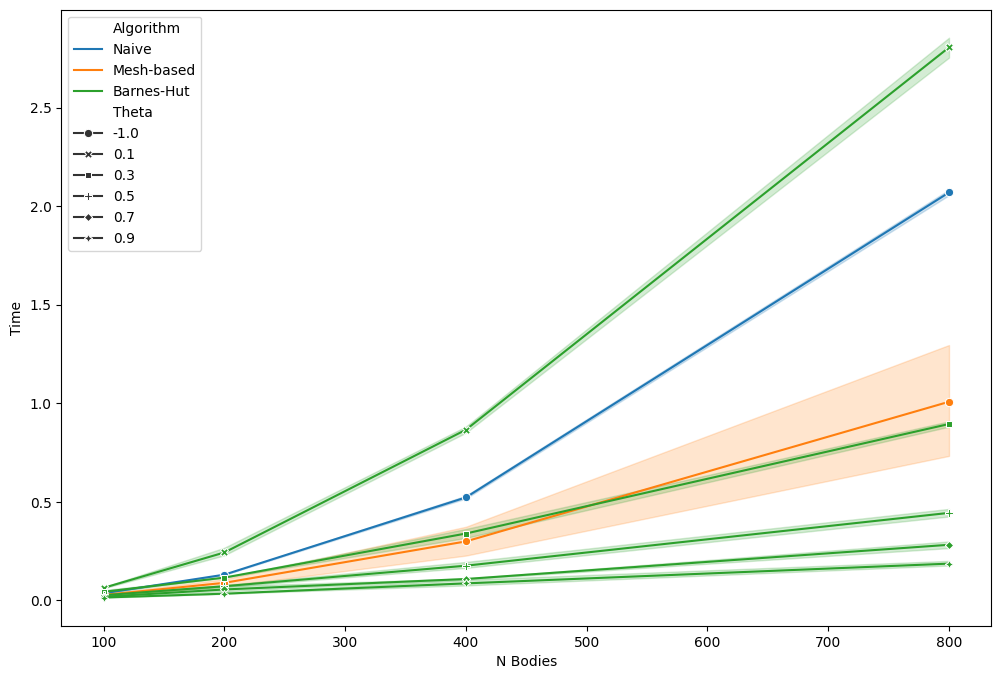

In [59]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
df_compare = all_dfs_combined.copy()
#df_compare = df_compare.drop(df_compare.index[df_compare["Theta"].isin(thetas[1:-1])])
#df_compare = df_compare.drop(df_compare.index[df_compare["Grid Size"].isin(mesh_sizes[1:-1])])
#df_compare["Algorithm"] = df_compare["Algorithm"] + df_compare["Grid Size"].fillna('').astype(str)
df_compare["Theta"] = df_compare["Theta"].fillna(-1.0)
df_compare["Grid Size"] = df_compare["Grid Size"].fillna(-1.0)
sns.lineplot(data=df_compare, x="N Bodies", y="Time", hue="Algorithm", style="Theta", markers=True, dashes=False, ax=ax)


### Pairwise checks count

In [72]:
def checks_algorithm(algorithm, alg_name, experiments, dt, steps=1, **kwargs):
    import time
    series_all = []
    for n_bodies, exps in experiments.items():
        check_sum = 0
        for experiment in exps:
            pos = experiment.positions.copy()
            vel = experiment.velocities.copy()
            mass = experiment.masses
            for _ in range(steps):
                pos, vel, checks = algorithm(pos, vel, mass, dt, **kwargs)
                check_sum += checks
            end_time = time.time()
            s = []
            s.append(alg_name)
            s.append(n_bodies)
            s.append(check_sum / len(exps))
            s.append(kwargs.get('theta', None))
            s.append(kwargs.get('grid_size', None))
            s = pd.Series(s, index=['Algorithm', 'N Bodies', 'Checks', 'Theta', 'Grid Size'])
            series_all.append(s)
    df = pd.DataFrame(series_all)
    return df

In [73]:
# naive
all_dfs = []
all_dfs.append(checks_algorithm(naive_comparison, "Naive", experiments, dt=0.01))

#mesh_based
mesh_sizes = [5, 10, 20, 50, 100]
for mesh_size in tqdm.tqdm(mesh_sizes):
    all_dfs.append(checks_algorithm(mesh_based_comparison, "Mesh-based", experiments, dt=0.01, grid_size=mesh_size))

# barnes_hut
thetas = [0.1, 0.3, 0.5, 0.7, 0.9]
for theta in tqdm.tqdm(thetas):
    all_dfs.append(checks_algorithm(barnes_hut_comparison, "Barnes-Hut", experiments, dt=0.01, theta=theta))

all_dfs_combined = pd.concat(all_dfs, ignore_index=True)

100%|██████████| 5/5 [00:34<00:00,  6.86s/it]
C:\Users\Admin\AppData\Local\Temp\ipykernel_32796\578707407.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_dfs_combined = pd.concat(all_dfs, ignore_index=True)


C:\Users\Admin\AppData\Local\Temp\ipykernel_32796\2022299414.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_compare["Grid Size"] = df_compare["Grid Size"].fillna(-1.0)


<Axes: xlabel='N Bodies', ylabel='Checks'>

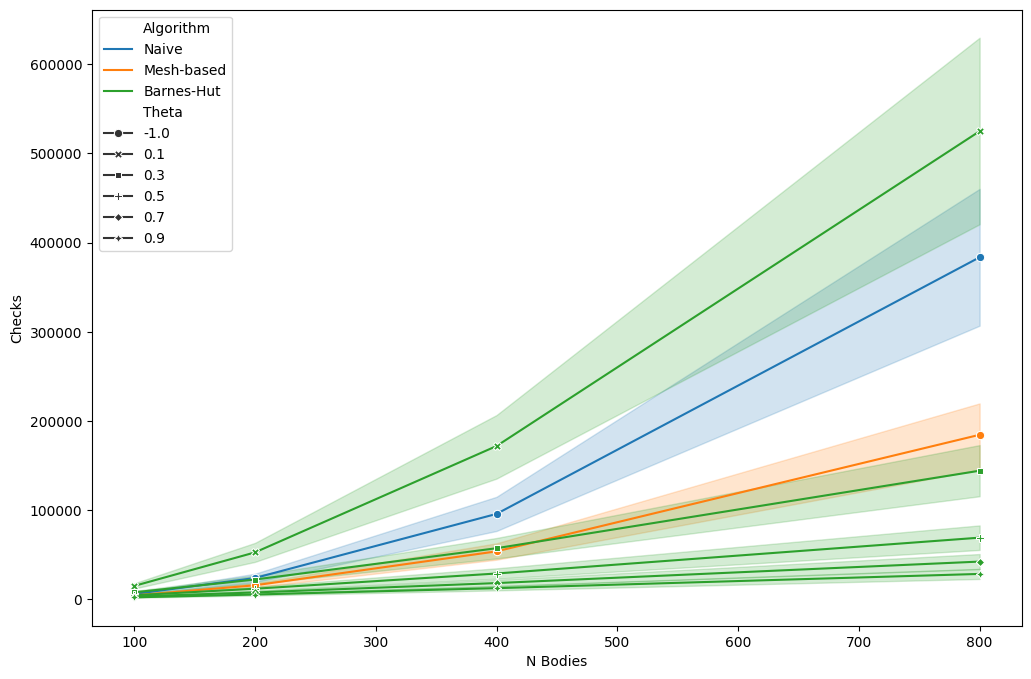

In [75]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
df_compare = all_dfs_combined.copy()
#df_compare = df_compare.drop(df_compare.index[df_compare["Theta"].isin(thetas[1:-1])])
#df_compare = df_compare.drop(df_compare.index[df_compare["Grid Size"].isin(mesh_sizes[1:-1])])
#df_compare["Algorithm"] = df_compare["Algorithm"] + df_compare["Grid Size"].fillna('').astype(str)
df_compare["Theta"] = df_compare["Theta"].fillna(-1.0)
df_compare["Grid Size"] = df_compare["Grid Size"].fillna(-1.0)
sns.lineplot(data=df_compare, x="N Bodies", y="Checks", hue="Algorithm", style="Theta", markers=True, dashes=False, ax=ax, errorbar=('ci', 68))

## Accuracy comparison

In [64]:
def accuracy_algorithms(experiments, dt, steps=3):
    series_all = []
    for n_bodies, exps in experiments.items():
        times = []
        for experiment in tqdm.tqdm(exps):
            mass = experiment.masses
            baseline_pos = []
            baseline_vel = []
            # Get baseline from naive
            pos = experiment.positions.copy()
            vel = experiment.velocities.copy()
            for _ in range(steps):
                pos, vel, _ = naive_comparison(pos, vel, mass, dt)
                baseline_pos.append(pos)
                baseline_vel.append(vel)
            
            # Mesh based
            for grid_size in mesh_sizes:
                pos = experiment.positions.copy()
                vel = experiment.velocities.copy()
                for step in range(steps):
                    pos, vel, _ = mesh_based_comparison(pos, vel, mass, dt, grid_size=grid_size)
                error_pos = np.linalg.norm(pos - baseline_pos[-1]) / n_bodies
                error_vel = np.linalg.norm(vel - baseline_vel[-1]) / n_bodies

                s = []
                s.append("Mesh-based")
                s.append(n_bodies)
                s.append(error_pos)
                s.append(error_vel)
                s.append(None)
                s.append(grid_size)
                s = pd.Series(s, index=['Algorithm', 'N Bodies', 'Error_pos', 'Error_vel', 'Theta', 'Grid Size'])
                series_all.append(s)

            # Barnes-Hut
            for theta in thetas:
                pos = experiment.positions.copy()
                vel = experiment.velocities.copy()
                for step in range(steps):
                    pos, vel, _ = barnes_hut_comparison(pos, vel, mass, dt, theta=theta)
                error_pos = np.linalg.norm(pos - baseline_pos[-1]) / n_bodies
                error_vel = np.linalg.norm(vel - baseline_vel[-1]) / n_bodies

                s = []
                s.append("Barnes-Hut")
                s.append(n_bodies)
                s.append(error_pos)
                s.append(error_vel)
                s.append(theta)
                s.append(None)
                s = pd.Series(s, index=['Algorithm', 'N Bodies', 'Error_pos', 'Error_vel', 'Theta', 'Grid Size'])
                series_all.append(s)
    df = pd.DataFrame(series_all)
    return df

In [65]:
df = accuracy_algorithms(experiments, dt=0.1)

100%|██████████| 5/5 [03:03<00:00, 36.61s/it]


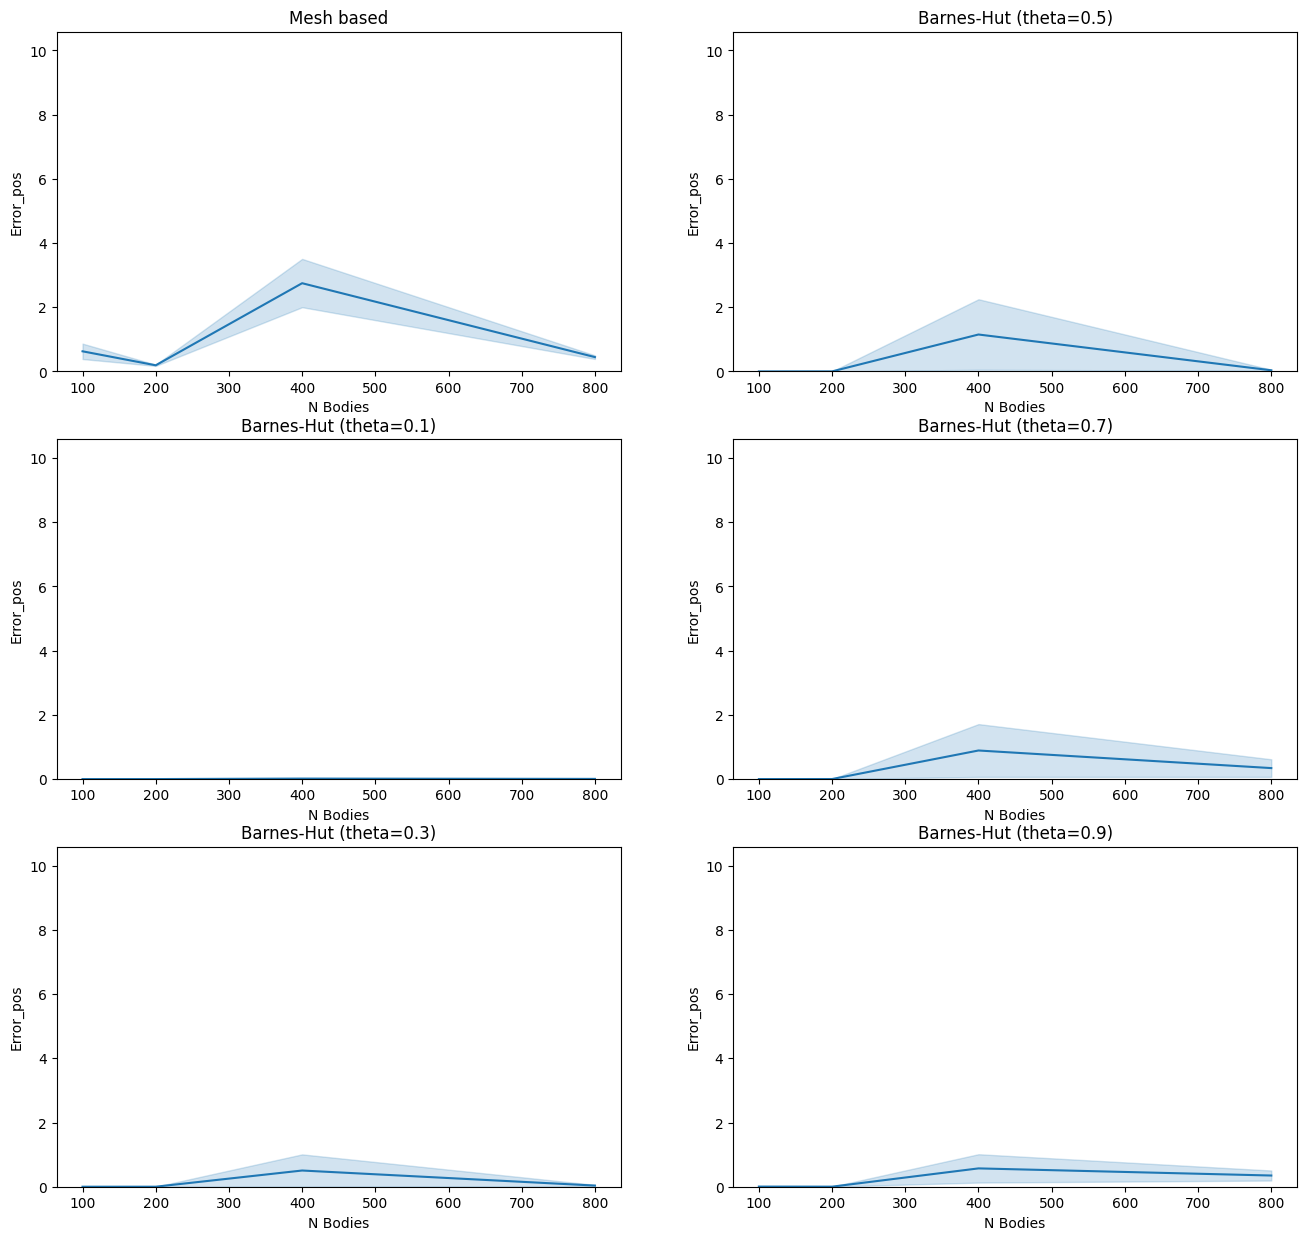

In [76]:
fig, axes = plt.subplots(3, 2, figsize=(16, 15))
df_compare = df.copy()
y_max = df_compare["Error_pos"].max() * 1.1
#df_compare = df_compare.drop(df_compare.index[df_compare["Theta"].isin(thetas[1:-1])])
#df_compare = df_compare.drop(df_compare.index[df_compare["Grid Size"].isin(mesh_sizes[1:-1])])
#df_compare["Algorithm"] = df_compare["Algorithm"] + df_compare["Grid Size"].fillna('').astype(str)
df_compare["Theta"] = df_compare["Theta"].fillna(-1.0)
df_compare["Grid Size"] = df_compare["Grid Size"].fillna(-1.0)
axes[0,0].set_title("Mesh based")
axes[0,0].set_ylim(0, y_max)
sns.lineplot(data=df_compare.loc[df_compare["Algorithm"] == "Mesh-based"], x="N Bodies", y="Error_pos", markers=True, dashes=False, ax=axes[0, 0], errorbar=('ci', 68))
i = 1
for theta in thetas:
    axes[i % 3, i // 3].set_title(f"Barnes-Hut (theta={theta})")
    axes[i % 3, i // 3].set_ylim(0, y_max)
    sns.lineplot(data=df_compare.loc[(df_compare["Algorithm"] == "Barnes-Hut") & (df_compare["Theta"] == theta)], x="N Bodies", y="Error_pos", markers=True, dashes=False, ax=axes[i % 3, i // 3], errorbar=('ci', 68))
    i += 1

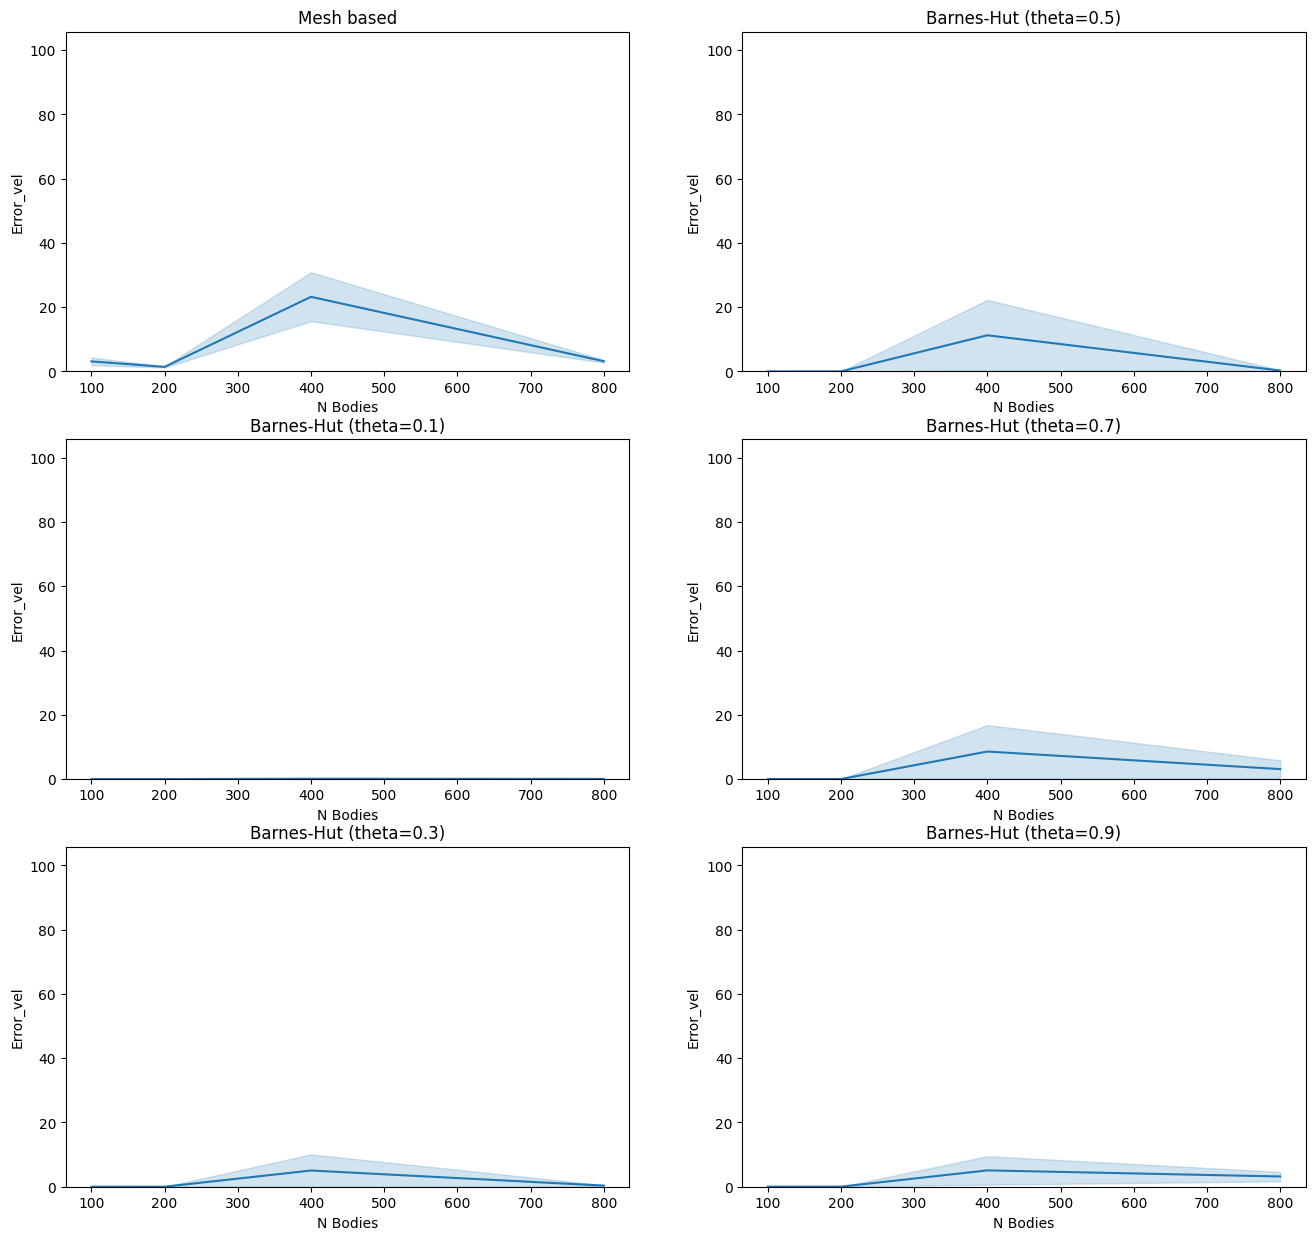

In [77]:
fig, axes = plt.subplots(3, 2, figsize=(16, 15))
df_compare = df.copy()
y_max = df_compare["Error_vel"].max() * 1.1
#df_compare = df_compare.drop(df_compare.index[df_compare["Theta"].isin(thetas[1:-1])])
#df_compare = df_compare.drop(df_compare.index[df_compare["Grid Size"].isin(mesh_sizes[1:-1])])
#df_compare["Algorithm"] = df_compare["Algorithm"] + df_compare["Grid Size"].fillna('').astype(str)
df_compare["Theta"] = df_compare["Theta"].fillna(-1.0)
df_compare["Grid Size"] = df_compare["Grid Size"].fillna(-1.0)
axes[0,0].set_title("Mesh based")
axes[0,0].set_ylim(0, y_max)
sns.lineplot(data=df_compare.loc[df_compare["Algorithm"] == "Mesh-based"], x="N Bodies", y="Error_vel", markers=True, dashes=False, ax=axes[0, 0], errorbar=('ci', 68))
i = 1
for theta in thetas:
    axes[i % 3, i // 3].set_title(f"Barnes-Hut (theta={theta})")
    axes[i % 3, i // 3].set_ylim(0, y_max)
    sns.lineplot(data=df_compare.loc[(df_compare["Algorithm"] == "Barnes-Hut") & (df_compare["Theta"] == theta)], x="N Bodies", y="Error_vel", markers=True, dashes=False, ax=axes[i % 3, i // 3], errorbar=('ci', 68))
    i += 1